In [2]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
import numpy as np
from utils import (ToreNet,get_default_args,BucketDataset,number_of_parameters,train_loop)

assert torch.cuda.is_available()

In [59]:
args = get_default_args()
args.conditioning_mode = "concat"

model = ToreNet(args)
model.to("cuda")

dataset = BucketDataset(im_reshape=(args.im_size,args.im_size))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)

number_of_parameters(model)

losses = {"train_loss": [],
      "vali_loss": [],
      "train_iou": [],
      "vali_iou": []}
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
train_loop(model, optimizer, train_dataloader, val_dataloader, args, losses)

model has 3705827 trainable parameters


train loss: 0.172, train iou: 0.838, vali loss: 0.193, vali iou: 0.832: 100%|██████████| 70/70 [00:06<00:00, 11.31it/s]


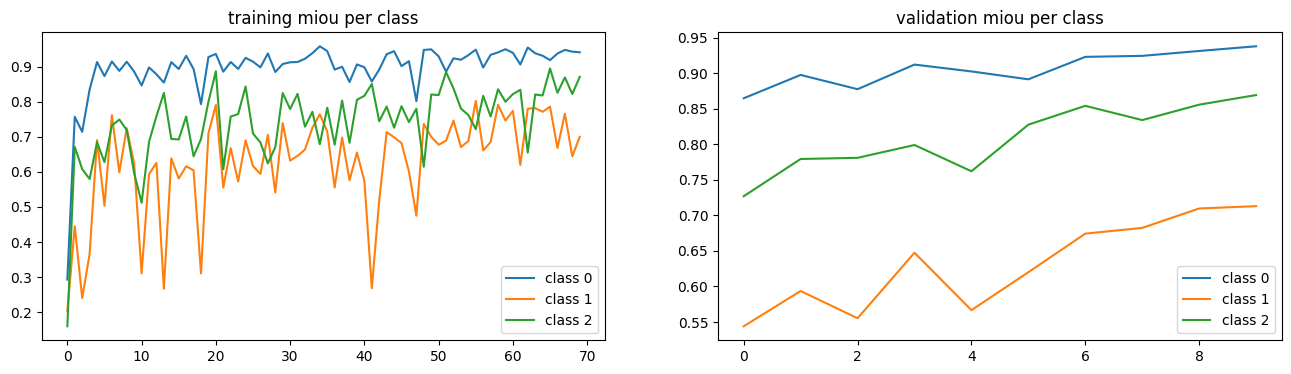

In [60]:
#plot iou/jaccard index plot (per class)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("training miou per class")
plt.plot(losses["train_iou"])
plt.legend(["class "+str(i) for i in range(args.num_classes)])
plt.subplot(1,2,2)
plt.title("validation miou per class")
plt.plot(losses["vali_iou"])
plt.legend(["class "+str(i) for i in range(args.num_classes)])

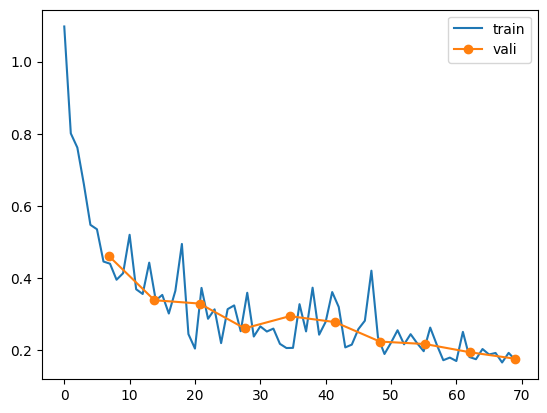

In [61]:
#plot loss plot
plt.plot(losses["train_loss"], label="train")
vali_ites = np.linspace(0,len(losses["train_loss"])-1,len(losses["vali_loss"])+1)[1:]
plt.plot(vali_ites,losses["vali_loss"], "o-",label="vali")
plt.legend()

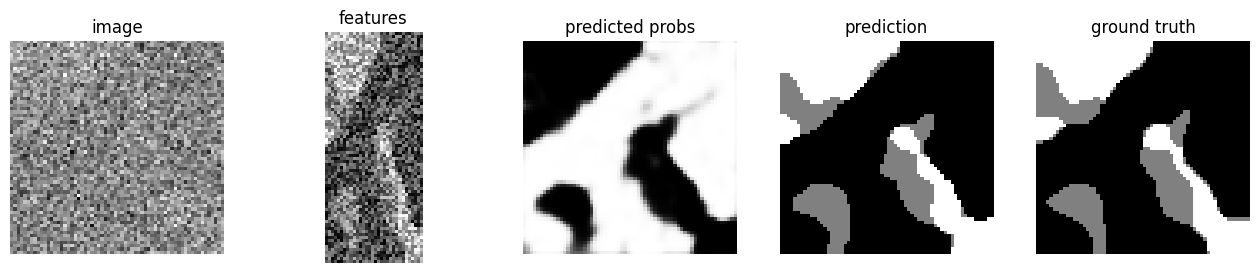

In [63]:
#plot a prediction
features, image, ground_truth = next(iter(val_dataloader))
features, image, ground_truth = (features.to(args.device), 
                        image.to(args.device), 
                        ground_truth.to(args.device))
pred = model(image, features)
probabilities = torch.softmax(pred, dim=1)

image_titles = ["image","features","predicted probs", "prediction", "ground truth"]
images = [image, features, probabilities, torch.argmax(probabilities, dim=1).unsqueeze(1), ground_truth]
plt.figure(figsize=(16,3))
for i in range(len(images)):
    plt.subplot(1,len(images),i+1)
    plt.title(image_titles[i])
    plt.imshow(images[i][0][0].detach().cpu().numpy(), cmap="gray")
    plt.axis("off")
